torch.Size([1000, 1000])
tensor(1.)


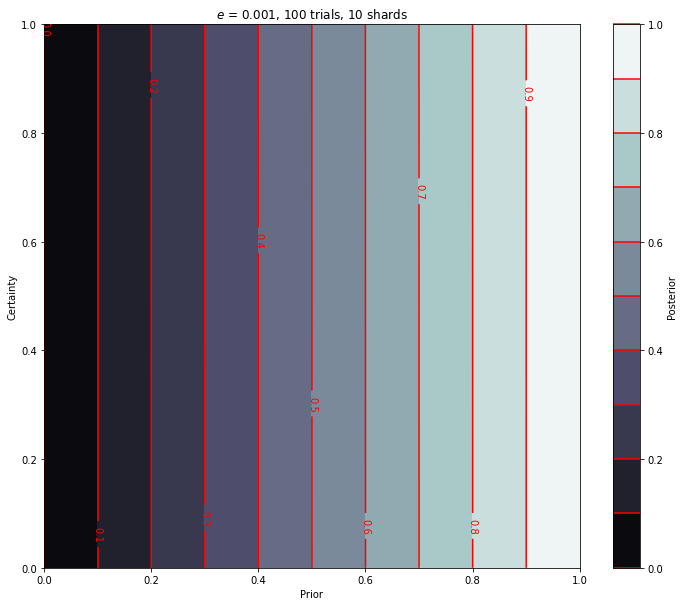

In [20]:
import matplotlib.pyplot as plt
import numpy as np

import polygraphs as pg
import torch


def generator(epsilon, trials, size):
    # Action B yields Bernoulli payoff of 1 (success)
    # with probability p (= 0.5 + e)
    probs = pg.init.halfs(size) + epsilon
    
    # Number of Bernoulli trials
    count = pg.init.zeros(size) + trials

    # Each node gets a private signal that provides information
    # about whether action B is indeed a good action
    sampler = torch.distributions.binomial.Binomial(total_count=count, probs=probs)
    return sampler

def jeffrey(prior, certainty, evidence):
    """
    Computes posterior based on Jeffrey's rule.
    """
    Z = pg.init.zeros((1000, 1000))
    for i in range(1000):
        Z[i] = pg.ops.math.jeffrey(prior, evidence, certainty[i])
    return Z


def jeffrey_inc(prior, certainty, evidence):
    """
    Computes posterior based on Jeffrey's rule.
    """
    Z = pg.init.zeros((1000, 1000))
    shards = 10
    sharded_evidence = pg.ops.math.Evidence(evidence.logits, evidence.values / shards, evidence.trials / 10)
    for i in range(1000):
        Z[i] = pg.ops.math.jeffrey(prior, sharded_evidence, certainty[i])
        for _ in range(shards - 1):
            Z[i] = pg.ops.math.jeffrey(Z[i], sharded_evidence, certainty[i])
    return Z


# Probability of success is 0.5 + epsilon
epsilon1 = 0.001

# Number of trials per node
trials = 100

size = 1000

prior = torch.tensor(np.linspace(0.0, 1.0, 1000))
# print("Prior is", prior)

certainty = np.linspace(0.0, 1.0, 1000)

g1 = generator(epsilon1, trials, size)

e1 = pg.ops.math.Evidence(g1.logits, g1.mean, g1.total_count)

posterior1 = jeffrey_inc(prior, certainty, e1)

print(posterior1.shape)
print(torch.max(posterior1))

# plt.clim(0, 1)

fig, ax = plt.subplots(1, 1, figsize=(12,10))

# fig = plt.figure()
# ax = plt.axes(projection='3d')

# ax.set_aspect('equal')

ax.set(xlabel="Prior")
ax.set(ylabel="Certainty")

ax.set_title(f"$e$ = {epsilon1}, {trials} trials, 10 shards")

cf = ax.contourf(prior, certainty, posterior1, levels=10, cmap=plt.cm.bone)

cf2 = ax.contour(cf, colors='r')

ax.clabel(cf2, inline=True, fontsize=10)

cbar = fig.colorbar(cf, ax=ax)

cbar.ax.set_ylabel('Posterior')
# Add the contour line levels to the colorbar
cbar.add_lines(cf2)

# ax.plot(prior, posterior1, color="red")
# ax.plot(prior, posterior2, color="blue")
# ax.plot(prior, posterior3, color="green")


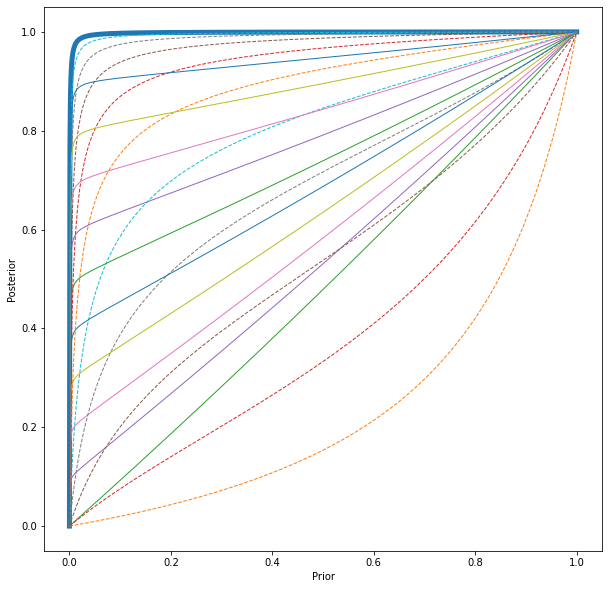

In [64]:
import matplotlib.pyplot as plt
import numpy as np

import polygraphs as pg
import torch


def generator(epsilon, trials, size):
    # Action B yields Bernoulli payoff of 1 (success)
    # with probability p (= 0.5 + e)
    probs = pg.init.halfs(size) + epsilon
    
    # Number of Bernoulli trials
    count = pg.init.zeros(size) + trials

    # Each node gets a private signal that provides information
    # about whether action B is indeed a good action
    sampler = torch.distributions.binomial.Binomial(total_count=count, probs=probs)
    return sampler


def jeffrey(prior, certainty, evidence, size):
    """
    Computes posterior based on Jeffrey's rule.
    """
    Z = pg.init.zeros((size, size))
    for i in range(size):
        Z[i] = pg.ops.math.jeffrey(prior, evidence, certainty[i])
    return Z


def jeffrey2(prior, certainty, evidence, size, shards=None):
    """
    Computes posterior based on Jeffrey's rule.
    """
    Z = pg.ops.math.jeffrey(prior, evidence, certainty)
    return Z


def jeffreyinc(prior, certainty, evidence, size, shards=10):
    """
    Computes posterior based on Jeffrey's rule incremental.
    """
    Z = pg.init.zeros((size, size))
    # Shard the evidence
    e = pg.ops.math.Evidence(evidence.logits, evidence.values / shards, evidence.trials / shards)
    for i in range(size):
        Z[i] = pg.ops.math.jeffrey(prior, e, certainty[i])
        for _ in range(shards - 1):
            Z[i] = pg.ops.math.jeffrey(Z[i], e, certainty[i])
    return Z


def jeffreyinc2(prior, certainty, evidence, size, shards=10):
    """
    Computes posterior based on Jeffrey's rule incremental.
    """
    # Shard the evidence
    e = pg.ops.math.Evidence(evidence.logits, evidence.values / shards, evidence.trials / shards)
    Z = pg.ops.math.jeffrey(prior, e, certainty)
    for _ in range(shards - 1):
        Z = pg.ops.math.jeffrey(Z, e, certainty)
    return Z


# Probability of success is 0.5 + epsilon
epsilon1 = 0.1

# Number of trials per node
trials = 100

size = 1000

prior = torch.tensor(np.linspace(0.0, 1.0, size))
# print("Prior is", prior)

certainty = np.linspace(0.0, 1.0, size)

g1 = generator(epsilon1, trials, size)

e1 = pg.ops.math.Evidence(g1.logits, g1.mean, g1.total_count)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.set(xlabel="Prior")
ax.set(ylabel="Posterior")
# ax.set(xlim=[0, 1])
# ax.set(ylim=[0, 1])

ax.plot(prior, pg.ops.math.bayes(prior, e1), linewidth=5)

# Let's compute Jeffrey's rule

C = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for k in C:
    post1 = jeffreyinc2(prior, k, e1, size, shards=10)
    ax.plot(prior, post1, "--", linewidth=1, label=f"{C}")
    post2 = jeffrey2(prior, k, e1, size, shards=10)
    ax.plot(prior, post2, linewidth=1, label=f"{C}")